# An RNN model to generate sequences
RNN models can generate long sequences based on past data. This can be used to predict stock markets, temperatures, traffic or sales data based on past patterns. They can also be adapted to [generate text](https://docs.google.com/presentation/d/18MiZndRCOxB7g-TcCl2EZOElS5udVaCuxnGznLnmOlE/pub?slide=id.g139650d17f_0_1185). The quality of the prediction will depend on training data, network architecture, hyperparameters, the distance in time at which you are predicting and so on. But most importantly, it will depend on wether your training data contains examples of the behaviour patterns you are trying to predict.

<div class="alert alert-block alert-warning">
This is the solution file. The corresponding tutorial file is [01_RNN_generator_playground.ipynb](01_RNN_generator_playground.ipynb)
</div>

In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import utils_prettystyle
import utils_batching
import tensorflow as tf
print("Tensorflow version: " + tf.__version__)

Tensorflow version: 1.6.0


## Load temperatures (Seattle, university of WA campus)

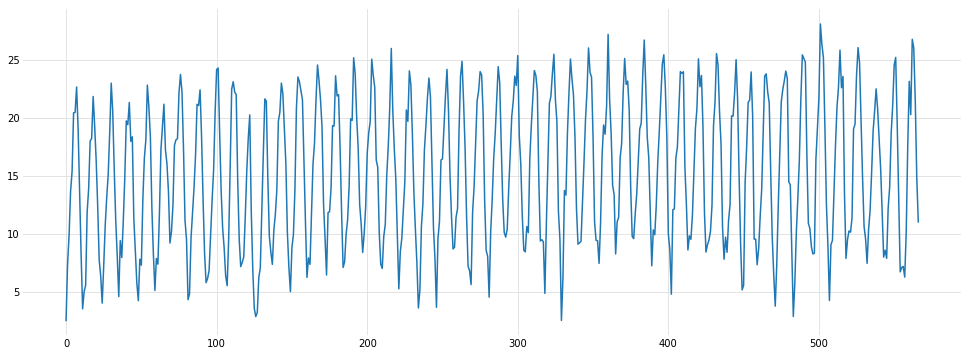

[ 2.57333333  7.42        9.92       13.7        15.41333333 20.47333333
 20.50666667 22.7        19.14       13.65333333  8.22        3.57666667
  5.06666667  5.59333333 11.91666667 13.92       18.05       18.26333333
 21.88333333 19.32666667 16.38333333 12.46333333  7.79666667  6.42
  4.07        7.26       10.77       13.18       15.18666667 18.83
 23.03333333 20.55666667 15.55333333 11.16666667  8.09666667  4.63
  9.46        7.99333333 11.15       14.85       19.77666667 19.44666667
 21.36666667 18.01666667 18.40333333 11.36666667  8.49666667  5.80333333
  4.28        7.86        7.33666667 13.00333333 16.55       18.17
 22.86333333 20.96       18.41666667 12.25666667  8.28        5.16
  7.92333333  7.42666667 11.76333333 17.28       19.20666667 21.21666667
 17.3        16.09333333 13.71666667  9.25       10.24333333 12.55333333
 17.67333333 18.14666667 18.24333333 22.20666667 23.78666667 22.26
 17.37       11.19        9.57        4.36666667  4.87        9.68333333
 11.84       1

In [2]:
temperatures = np.genfromtxt(open("temperatures/univ_of_wa_temperatures.csv", "rb"), delimiter=",", skip_header=True,
                      usecols=[1,2,3], converters = {1: lambda s: np.datetime64(s)})
dates = temperatures[:]['f0']
min_temps = temperatures[:]['f1']
max_temps = temperatures[:]['f2']

DATA_SEQ_LEN = max_temps.shape[0]
data = np.nan_to_num(max_temps[0:17010]) ## Hack, must clean the data properly. Also, skipping dates !!
data = np.reshape(data, [-1, 30])
data = np.mean(data, axis=1)
#plt.plot(dates[0:700], data[0:700])
plt.plot(data)
plt.show()
print(data[0:2000])
print(dates[0:2000])

## Hyperparameters

In [3]:
RNN_CELLSIZE = 64   # size of the RNN cells
NLAYERS = 2         # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 32         # unrolled sequence length
BATCHSIZE = 6      # mini-batch size
DROPOUT_PKEEP = 0.7 # probability of neurons not being dropped (should be between 0.5 and 1)

## Visualize training sequences
This is what the neural network will see during training.

Sample shape: (6, 32)
Label shape: (6, 32)
Excerpt from first batch:


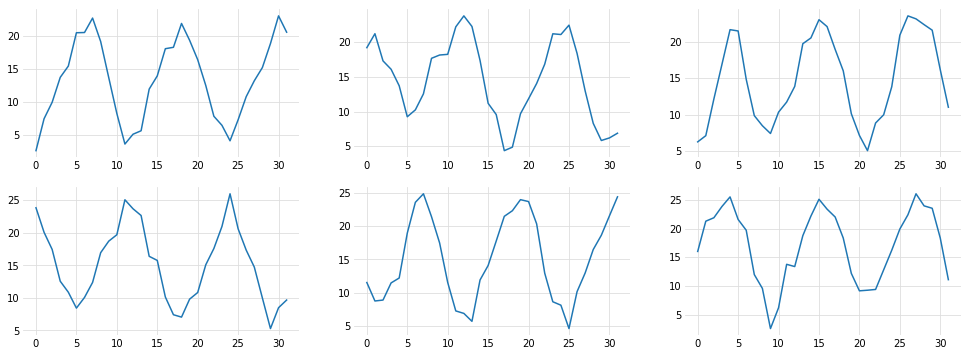

In [4]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for samples, labels, epoch in utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Sample shape: " + str(samples.shape))
print("Label shape: " + str(labels.shape))
print("Excerpt from first batch:")
subplot = 231
for i in range(6):
    plt.subplot(subplot)
    plt.plot(samples[i])
    subplot += 1
plt.show()

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.
![deep RNN schematic](images/deep_rnn.png)

In [5]:
def model_rnn_fn(features, Hin, labels, dropout_pkeep):
    X = features
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
    
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(NLAYERS)]
    # dropout useful between cell layers only: no output dropout on last cell
    dcells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    dcells.append(cells[-1])
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(dcells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*NLAYERS]
    # the sequence unrolling happens here
    Yn, H = tf.nn.dynamic_rnn(cell, X, initial_state=Hin, dtype=tf.float32)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:] # Last output Yout [BATCHSIZE, 1]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 1]
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op

## Instantiate the model

In [6]:
# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * NLAYERS])
samples = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
labels = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op = model_rnn_fn(samples, Hin, labels, dropout_pkeep)

## Inference
This is a generative model: run one trained RNN cell in a loop

In [7]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * NLAYERS]) # zero state initially
    Yout_ = np.zeros([1, 1])
    data_len = prime_data.shape[0]

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data)
        Yin = np.reshape(Yin, [1, data_len, 1]) # reshape as one sequence
        feed = {Hin: H_, samples: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
    
    # run prediction
    # To generate a sequence, run a trained cell in a loop passing as input and input state
    # respectively the output and output state from the previous iteration.
    results = []
    for i in range(run_length):
        Yout_ = np.reshape(Yout_, [1, 1, 1]) # batch of a single sequence of a single vector with one element
        feed = {Hin: H_, samples: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        results.append(Yout_[0,0])
        
    return np.array(results)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [8]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * NLAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
You can re-execute this cell to continue training

In [9]:
NB_EPOCHS = 500

H_ = Hzero
losses = []
indices = []
for i, (next_samples, next_labels, epoch) in enumerate(utils_batching.rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=NB_EPOCHS)):
    next_samples = np.expand_dims(next_samples, axis=2) # model wants 3D inputs [BATCHSIZE, SEQLEN, 1] 
    next_labels = np.expand_dims(next_labels, axis=2)

    feed = {Hin: H_, samples: next_samples, labels: next_labels, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, _ = sess.run([Yout, H, loss, train_op], feed_dict=feed)
    # print progress
    if i%30 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)

epoch 0, batch 0, loss=276.634
epoch 15, batch 30, loss=37.89011
epoch 30, batch 60, loss=36.768497
epoch 45, batch 90, loss=36.757957
epoch 60, batch 120, loss=36.757107
epoch 75, batch 150, loss=36.755955
epoch 90, batch 180, loss=36.75558
epoch 105, batch 210, loss=36.75471
epoch 120, batch 240, loss=34.472713
epoch 135, batch 270, loss=7.8241715
epoch 150, batch 300, loss=4.345509
epoch 165, batch 330, loss=3.9533708
epoch 180, batch 360, loss=3.5934265
epoch 195, batch 390, loss=3.3992844
epoch 210, batch 420, loss=3.4108756
epoch 225, batch 450, loss=2.99604
epoch 240, batch 480, loss=2.7086027
epoch 255, batch 510, loss=2.5403054
epoch 270, batch 540, loss=2.6328332
epoch 285, batch 570, loss=2.8060086
epoch 300, batch 600, loss=2.4507196
epoch 315, batch 630, loss=2.3576486
epoch 330, batch 660, loss=2.374388
epoch 345, batch 690, loss=2.0759869
epoch 360, batch 720, loss=1.9133085
epoch 375, batch 750, loss=1.9896642
epoch 390, batch 780, loss=1.8200936
epoch 405, batch 810, l

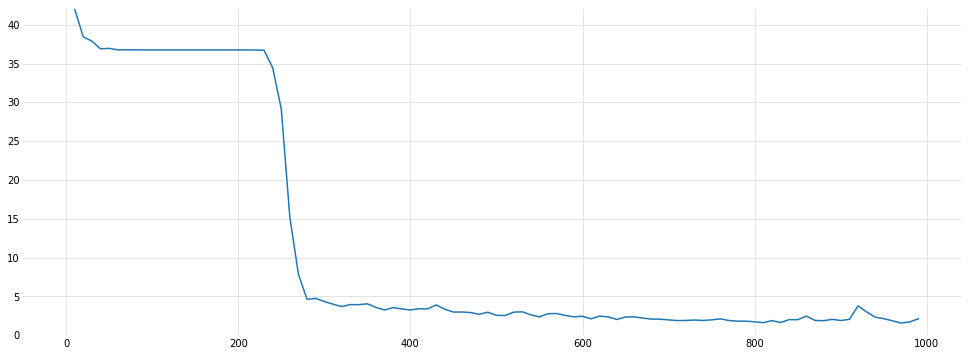

In [10]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

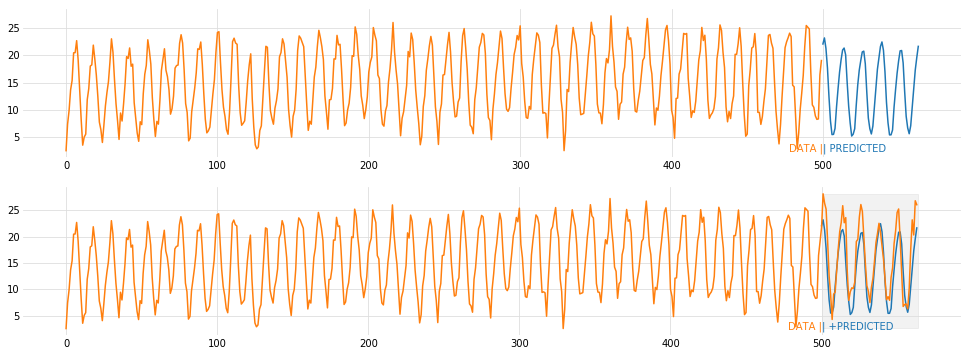

RMSE on 64 predictions (shaded area): 3.890425583602962


In [11]:
PRIMELEN=500
RUNLEN=64
OFFSET=0

prime_data = data[OFFSET:OFFSET+PRIMELEN]

results = prediction_run(prime_data, RUNLEN)

disp_data = data[OFFSET:OFFSET+PRIMELEN+RUNLEN]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.subplot(211)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| PREDICTED", color=colors[0], horizontalalignment="left")
displayresults = np.ma.array(np.concatenate((np.zeros([PRIMELEN]), results)))
displayresults = np.ma.masked_where(displayresults == 0, displayresults)
plt.plot(displayresults)
displaydata = np.ma.array(np.concatenate((prime_data, np.zeros([RUNLEN]))))
displaydata = np.ma.masked_where(displaydata == 0, displaydata)
plt.plot(displaydata)
plt.subplot(212)
plt.text(PRIMELEN,2.5,"DATA |", color=colors[1], horizontalalignment="right")
plt.text(PRIMELEN,2.5,"| +PREDICTED", color=colors[0], horizontalalignment="left")
plt.plot(displayresults)
plt.plot(disp_data)
RMSELEN=64
plt.axvspan(PRIMELEN, PRIMELEN+RMSELEN, color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
plt.show()

rmse = math.sqrt(np.mean((data[OFFSET+PRIMELEN:OFFSET+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.